In [69]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

import numpy as np
import pandas as pd
import skforecast

print(skforecast.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/joaquin/Documents/GitHub/skforecast
0.19.1


In [70]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import skforecast
from skforecast.stats import Sarimax, Arar, Ets
from skforecast.recursive import ForecasterStats, ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold, backtesting_stats, backtesting_forecaster
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

from skforecast.plot import set_dark_theme
from skforecast.datasets import fetch_dataset
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import aeon
from aeon.forecasting.stats import ARIMA, ETS
import matplotlib.pyplot as plt
import timeit

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
print(f"skforecast version: {skforecast.__version__}")
print(f"aeon version      : {aeon.__version__}")

skforecast version: 0.19.1
aeon version      : 1.3.0


# Fuel consumption dataset

In [71]:
# Download data
# ==============================================================================
data = fetch_dataset(name='fuel_consumption', raw=True)
data = data[['Fecha', 'Gasolinas']]
data = data.rename(columns={'Fecha': 'date', 'Gasolinas': 'y'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.loc[:'1990-01-01 00:00:00', ['y']]
data['month'] = data.index.month
data = pd.get_dummies(data, columns=['month'], prefix='month', drop_first=False, dtype=float)
data

╭──────────────────────────────── fuel_consumption ────────────────────────────────╮
│ Description:                                                                     │
│ Monthly fuel consumption in Spain from 1969-01-01 to 2022-08-01.                 │
│                                                                                  │
│ Source:                                                                          │
│ Obtained from Corporación de Reservas Estratégicas de Productos Petrolíferos and │
│ Corporación de Derecho Público tutelada por el Ministerio para la Transición     │
│ Ecológica y el Reto Demográfico. https://www.cores.es/es/estadisticas            │
│                                                                                  │
│ URL:                                                                             │
│ https://raw.githubusercontent.com/skforecast/skforecast-                         │
│ datasets/main/data/consumos-combustibles-mensual.csv                             │
│                                                                                  │
│ Shape: 644 rows x 6 columns                                                      │
╰──────────────────────────────────────────────────────────────────────────────────╯

,y,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,
1969-01-01,166875.2129,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-02-01,155466.8105,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-03-01,184983.6699,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-04-01,202319.8164,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-05-01,206259.1523,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989-09-01,687649.2852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1989-10-01,669889.1602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1989-11-01,601413.8867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Train dates : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Test dates  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


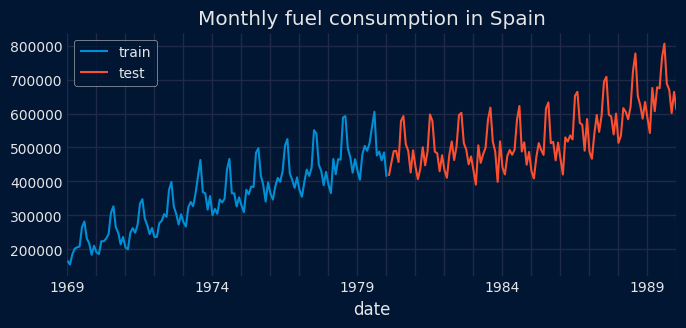

In [72]:
# Train-test dates
# ======================================================================================
set_dark_theme()
end_train = '1980-01-01 23:59:59'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

# Compare ets from skforecast, aeon and statsmodels

In [73]:
start = timeit.default_timer()
forecaster = ForecasterStats(
                estimator = Ets(
                    model="AMM",        # Additive error ("A"), no trend ("N"), no seasonal ("N")
                    damped=False,       # No damped trend
                    m=12,                # Seasonal period (irrelevant since no seasonal, but default is 1)
                    lambda_param=None,  # No Box-Cox transformation
                    lambda_auto=False,  # No automatic Box-Cox
                    bounds="both"       # Default bounds (similar to statsmodels' None, which uses internal defaults)
                )
            )
forecaster.fit(y=data_train['y'])
end = timeit.default_timer()
time_fit_ets_skforecast = end - start
print(f"Training time ETS skforecast  : {time_fit_ets_skforecast} seconds")
start = timeit.default_timer()
predictions_skforecast = forecaster.predict(steps=24)
end = timeit.default_timer()
time_pred_ets_skforecast = end - start
prediction_intervals_skforecast = forecaster.predict_interval(steps=24, alpha=0.05)
print(f"Prediction time ETS skforecast: {time_pred_ets_skforecast} seconds")

Training time ETS skforecast  : 0.03209630399942398 seconds
Prediction time ETS skforecast: 0.004805806995136663 seconds


In [74]:
start = timeit.default_timer()
forecaster = ForecasterStats(
                 estimator=ETS(error_type='additive', trend_type='additive', seasonality_type='multiplicative', seasonal_period=12)
             )
forecaster.fit(y=data_train['y'])
end = timeit.default_timer()
time_fit_ets_aeon = end - start
print(f"Training time ETS aeon  : {time_fit_ets_aeon} seconds")
start = timeit.default_timer()
predictions_aeon = forecaster.predict(steps=24)
end = timeit.default_timer()
time_pred_ets_aeon = end - start
# prediction_intervals_aeon = forecaster.predict_interval(steps=24, alpha=0.05)
print(f"Prediction time ETS aeon: {time_pred_ets_aeon} seconds")

Training time ETS aeon  : 0.003170693998981733 seconds
Prediction time ETS aeon: 0.0016698909967090003 seconds


In [75]:
start = timeit.default_timer()
model = ExponentialSmoothing(
    data_train['y'],
    trend='add',
    seasonal='mul',
    seasonal_periods=12
).fit()
end = timeit.default_timer()
time_fit_ets_statsmodels = end - start
print(f"Training time ETS statsmodels  : {time_fit_ets_statsmodels} seconds")
start = timeit.default_timer()
predictions_statsmodels = model.forecast(steps=24)
end = timeit.default_timer()
time_pred_ets_statsmodels = end - start
resid = model.resid
sigma = resid.std(ddof=1)
z = 1.96
h_index = np.arange(1, 24 + 1)
lower_approx = predictions_statsmodels - z * sigma * np.sqrt(h_index)
upper_approx = predictions_statsmodels + z * sigma * np.sqrt(h_index)
prediction_intervals_statsmodels = pd.DataFrame({
    'lower_bound': lower_approx,
    'upper_bound': upper_approx
})

print(f"Prediction time ETS statsmodels: {time_pred_ets_statsmodels} seconds")

Training time ETS statsmodels  : 0.10712384399812436 seconds
Prediction time ETS statsmodels: 0.007478754996554926 seconds


In [76]:
# Table of times
# ==============================================================================
times_ets = pd.DataFrame({
    'fit_time_seconds': [time_fit_ets_skforecast, time_fit_ets_aeon, time_fit_ets_statsmodels],
    'predict_time_seconds': [time_pred_ets_skforecast, time_pred_ets_aeon, time_pred_ets_statsmodels]
}, index=['ETS skforecast', 'ETS aeon', 'ETS statsmodels'])
times_ets.sort_values(by='fit_time_seconds')

,fit_time_seconds,predict_time_seconds
ETS aeon,0.003171,0.001670
ETS skforecast,0.032096,0.004806
ETS statsmodels,0.107124,0.007479


,skforecast,aeon,statsmodels
1980-02-01,419019.957822,415913.953887,415845.763257
1980-03-01,487582.742761,484605.626584,483093.518480
1980-04-01,504077.943837,487726.359076,497800.142558
1980-05-01,505294.042465,483728.370592,499527.252473
1980-06-01,524043.119332,495274.057561,519031.538186
1980-07-01,638621.305438,582314.444362,626287.531650
1980-08-01,668104.724836,604727.928882,653098.919874
1980-09-01,543251.473217,493895.652010,532150.599667
1980-10-01,519066.309461,486423.494714,513349.105935
1980-11-01,463176.798524,447959.513269,464009.628076


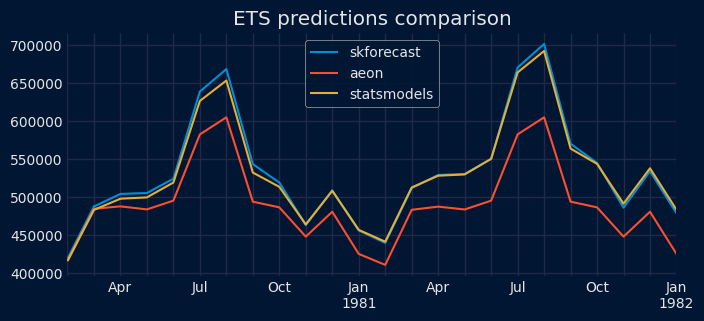

In [63]:
# compare predictions
# ======================================================================================
predictions = pd.DataFrame({
    'skforecast': predictions_skforecast,
    'aeon'      : predictions_aeon,
    'statsmodels': predictions_statsmodels
})
display( predictions )
predictions.plot(figsize=(7, 3), title='ETS predictions comparison');

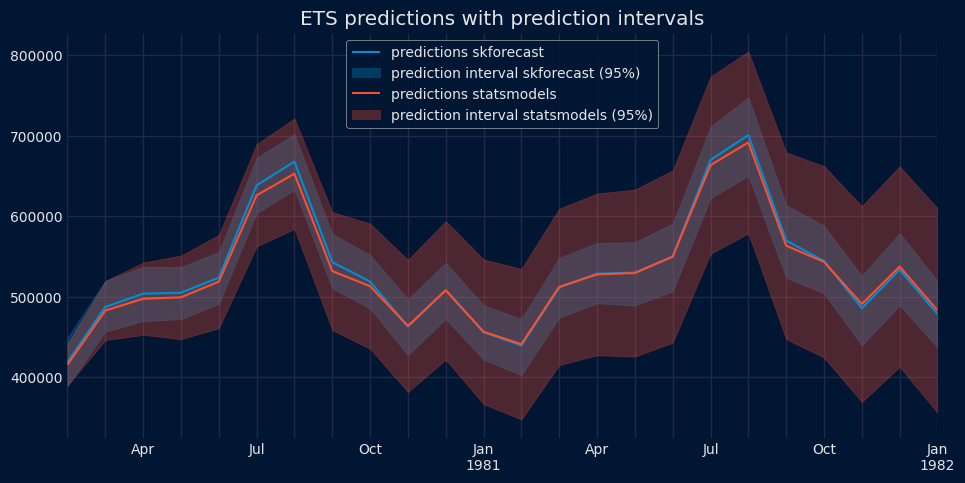

In [64]:
# Plot predictions with prediction intervals
# ======================================================================================
fig, ax = plt.subplots(figsize=(10, 5))
predictions_skforecast.plot(ax=ax, label='predictions skforecast', color='C0')
ax.fill_between(
    prediction_intervals_skforecast.index,
    prediction_intervals_skforecast['lower_bound'],
    prediction_intervals_skforecast['upper_bound'],
    color='C0',
    alpha=0.3,
    label='prediction interval skforecast (95%)'
)
predictions_statsmodels.plot(ax=ax, label='predictions statsmodels', color='C1')
ax.fill_between(
    prediction_intervals_statsmodels.index,
    prediction_intervals_statsmodels['lower_bound'],
    prediction_intervals_statsmodels['upper_bound'],
    color='C1',
    alpha=0.3,
    label='prediction interval statsmodels (95%)'
)
ax.set_title('ETS predictions with prediction intervals')
ax.legend();

In [65]:
# Backtesting ForecasterStats with ETS skforecast
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True,
        fixed_train_size   = False,
)
forecaster = ForecasterStats(
                 estimator=Ets(
                    model="AMM",        # Additive error ("A"), no trend ("N"), no seasonal ("N")
                    damped=False,       # No damped trend
                    m=12,                # Seasonal period (irrelevant since no seasonal, but default is 1)
                    lambda_param=None,  # No Box-Cox transformation
                    lambda_auto=False,  # No automatic Box-Cox
                    bounds="both"       # Default bounds (similar to statsmodels' None, which uses internal defaults)
                )
             )

start = timeit.default_timer()
metric_ets_skforecast, pred_ets_skforecast = backtesting_stats(
    forecaster = forecaster,
    y          = data['y'],
    cv         = cv,
    metric     = 'mean_absolute_error'
)
stop = timeit.default_timer()
elapsed_time_ets_skforecast = stop - start

  0%|          | 0/10 [00:00<?, ?it/s]

In [66]:
# Backtesting ForecasterStats with ETS aeon
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True,
        fixed_train_size   = False,
)
forecaster = ForecasterStats(
                 estimator=ETS(error_type='additive', trend_type='additive', seasonality_type='multiplicative', seasonal_period=12),
             )

start = timeit.default_timer()
metric_ets_aeon, pred_ets_aeon = backtesting_stats(
    forecaster = forecaster,
    y          = data['y'],
    cv         = cv,
    metric     = 'mean_absolute_error'
)
stop = timeit.default_timer()
elapsed_time_ets_aeon = stop - start

  0%|          | 0/10 [00:00<?, ?it/s]

In [67]:
# Results
# ==============================================================================
results = pd.DataFrame(
    {
        "Model": [
            "Ets skforecast",
            "ETS aeon",
        ],
        "MAE": [
            
            metric_ets_skforecast.at[0, "mean_absolute_error"],
            metric_ets_aeon.at[0, "mean_absolute_error"],
        ],
        "Elapsed Time (s)": [
            elapsed_time_ets_skforecast,
            elapsed_time_ets_aeon,
        ],
    }
)
results = results.sort_values(by="MAE").reset_index(drop=True)
results

,Model,MAE,Elapsed Time (s)
0,ETS aeon,19848.024097,0.128384
1,Ets skforecast,19955.289366,0.438002


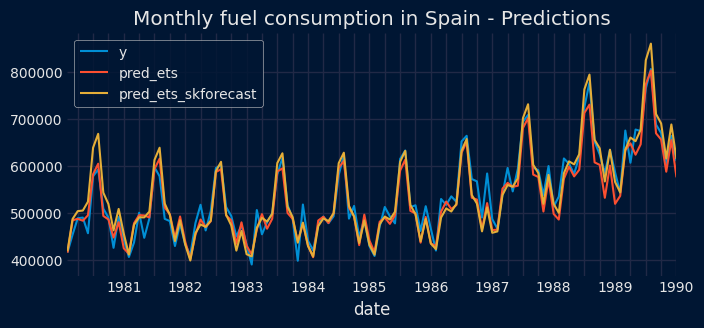

In [68]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data['y'].loc[data_test.index].plot(ax=ax, label='y')
pred_ets_aeon['pred'].plot(ax=ax, label='pred_ets')
pred_ets_skforecast['pred'].plot(ax=ax, label='pred_ets_skforecast')
ax.set_title('Monthly fuel consumption in Spain - Predictions')
ax.legend();